In [115]:
from langchain_groq import ChatGroq
from langchain.schema import HumanMessage

import os

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.0,
    api_key=os.getenv("GROQ_API_KEY")
)

history = """User: hii my name is Omar and i am Computer Engineering Fresh Graduate
Assistant: Hello Omar! Congratulations on your recent graduation in Computer Engineering! That's a fantastic achievement. What are your plans now that you've completed your degree? Are you looking to pursue a master's degree, or are you interested in exploring job opportunities in the field of computer engineering? I'm here to help and offer any guidance or advice if you need it!
"""

question = "do you remember my name ? and can you wildly guess my age through previous conversations?"

prompt = f"""
Answer the following question based on the previous conversation history. 
If the question asks about personal information like name or age, rely only on what was explicitly mentioned before.

Question: {question}

Conversation so far:
{history}
"""

response = llm.invoke([HumanMessage(content=prompt)])
print(response.content)

I remember your name, it's Omar. 

As for your age, I can make a wild guess based on the fact that you're a fresh graduate. Typically, students graduate with a bachelor's degree around the age of 21-23. Considering that, I'm going to take a wild guess and say you might be around 22 years old. Please keep in mind that this is just a rough estimate and not an accurate prediction.


In [110]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.faiss import FAISS
from langchain.chains.retrieval_qa.base import RetrievalQA
from langgraph.graph import StateGraph, END
from typing import List
import os
from langchain_groq import ChatGroq
from langchain.schema import LLMResult, Generation
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_core.runnables import Runnable
from langchain_core.language_models import BaseLanguageModel
from typing import Any, Dict, List, Optional
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer
from langchain_community.vectorstores import Pinecone
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain_community.document_loaders import PyPDFLoader, TextLoader, CSVLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer
from sentence_transformers import CrossEncoder
import os
from langchain.schema import HumanMessage

load_dotenv()
# index for each type of data , dynamically add to the retriever database

True

In [2]:
#model = SentenceTransformer("models/e5-large-v2")
model = SentenceTransformer("models/e5-small-v2")

class E5Embedder:
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        return model.encode(texts, convert_to_numpy=True, normalize_embeddings=True).tolist()
    def embed_query(self, text: str) -> List[float]:
        return model.encode([text], convert_to_numpy=True, normalize_embeddings=True)[0].tolist()

In [3]:
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.6,
    api_key = os.getenv("GROQ_API_KEY")
)
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_ENV = os.getenv("PINECONE_ENV") 

pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"), environment=PINECONE_ENV)
INDEX_NAME = "multi-doc-index" 


In [40]:
split_pdf_docs = [Document("HI THIS IS PREFLMR AGENT AGAIN AGAIN"),Document(
                    page_content="HI THIS IS PREFLMR AGENT AGAIN",
                    metadata={
                        "file_name": "agent_intro.txt",
                        "source": "manual_upload",
                        "timestamp": "2025-11-05"
                    }),
                  Document(
                    page_content="THIS IS NOT PREFLMR",
                    metadata={
                        "file_name": "agent_intro.txt",
                        "source": "manual_upload",
                        "timestamp": "2025-11-05"
                    }
                )]
vectorstore_pdf = PineconeVectorStore.from_documents(
            split_pdf_docs,
            embedding=E5Embedder(),
            namespace="txt",
            index_name=INDEX_NAME
        )


In [44]:
vectorstore = PineconeVectorStore(
                embedding=E5Embedder(),
                index_name=INDEX_NAME,
                namespace="txt"
            )         
vectorstore.delete(
    filter={"file_name": "agent_intro.txt"},
)

In [4]:
if INDEX_NAME not in [i.name for i in pc.list_indexes()]:
    pc.create_index(
        name=INDEX_NAME,
        dimension=384,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

index = pc.Index(INDEX_NAME)

In [5]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)

def clean(txt):
    # apply data cleaning if needed
    return txt

def prefix_passage_texts(split_docs):
    prefixed_docs = []
    for doc in split_docs:
        new_doc = Document(
            page_content="passage: " + clean(doc.page_content.strip()),
            metadata=doc.metadata
        )
        prefixed_docs.append(new_doc)
    return prefixed_docs

def ingestion_pipeline(doc_folder="./docs/"):
    # chunking based on type
    pdf_paths = [x for x in os.listdir(doc_folder) if x[-4:] == ".pdf"]
    text_paths = [x for x in os.listdir(doc_folder) if x[-4:] == ".txt"]

    pdf_docs = []
    for path in pdf_paths:
        loader = PyPDFLoader(os.path.join(doc_folder,path))
        pdf_docs.extend(loader.load())

    # clean pdf_docs
    if pdf_docs:
        # chunking
        split_pdf_docs = splitter.split_documents(pdf_docs)
        
        # cleaning
        split_pdf_docs = prefix_passage_texts(split_pdf_docs)

        
        print(f"Embedding {len(split_pdf_docs)} PDF chunks...")

        vectorstore_pdf = PineconeVectorStore.from_documents(
            split_pdf_docs,
            embedding=E5Embedder(),
            namespace="pdf",
            index_name=INDEX_NAME
        )

            
    # === Text ingestion ===
    text_docs = []
    for path in text_paths:
        loader = TextLoader(os.path.join(doc_folder, path))
        text_docs.extend(loader.load())

    if text_docs:
        #chunking
        split_text_docs = splitter.split_documents(text_docs)

        # cleaning
        split_text_docs = pprefix_passage_texts(split_text_docs)
        
        print(f"Embedding {len(split_text_docs)} Text chunks...")
        vectorstore_pdf = PineconeVectorStore.from_documents(
            split_text_docs,
            embedding=E5Embedder(),
            namespace="txt",
            index_name=INDEX_NAME
        )


In [6]:
ingestion_pipeline()

Embedding 254 PDF chunks...


In [9]:
PineconeVectorStore.__dict__.keys()

dict_keys(['__module__', '__annotations__', '__doc__', '_index', '_async_index', '__init__', 'index', 'async_index', 'embeddings', 'add_texts', 'aadd_texts', '__aenter__', '__aexit__', 'aclose', '_async_index_context', 'similarity_search_by_vector', 'asimilarity_search_by_vector', 'similarity_search_with_score', 'asimilarity_search_with_score', 'similarity_search_by_vector_with_score', 'asimilarity_search_by_vector_with_score', 'similarity_search', 'asimilarity_search', '_select_relevance_score_fn', '_cosine_relevance_score_fn', 'max_marginal_relevance_search_by_vector', 'amax_marginal_relevance_search_by_vector', 'max_marginal_relevance_search', 'amax_marginal_relevance_search', 'get_pinecone_index', 'from_texts', 'afrom_texts', 'from_existing_index', 'delete', 'adelete', '__abstractmethods__', '_abc_impl'])

In [29]:
# LangGraph nodes
vectorstore_pdf = PineconeVectorStore.from_existing_index(
    index_name=INDEX_NAME,
    embedding=E5Embedder(),
    namespace="pdf"   
)

vectorstore_text = PineconeVectorStore.from_existing_index(
    index_name=INDEX_NAME,
    embedding=E5Embedder(),
    namespace="text"   
)
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# i want the llm to decide if it has enough knowledge to answer the question before retrieving

def retrieve_node(state):
    query = "query: " + state["question"]

    # how does caching work with RAG
    # get relevant docs top 10 from each index and then rerank them all and select top 5 from the 30
    pdf_results = vectorstore_pdf.similarity_search(query, k=30)
    # csv_results = vectorstore_csv.similarity_search(query, k=30)
    text_results = vectorstore_text.similarity_search(query, k=30)
    # rerank and choose top 10
    all_results = pdf_results + text_results

    # Build pairs for cross-encoder input
    # make sure that csv is also a doc with page content
    pairs = [(query, doc.page_content) for doc in all_results]

    # Compute relevance scores
    scores = reranker.predict(pairs)

    # Combine scores with docs
    scored_docs = list(zip(all_results, scores))

    # Sort by descending score
    scored_docs = sorted(scored_docs, key=lambda x: x[1], reverse=True)

    # Take top 10
    top_docs = [doc for doc, _ in scored_docs[:5]]

    state["docs"] = top_docs
    return state

def answer_node(state):
    question = state["question"]
    # extract only passage
    docs = [x for x in state["docs"]]

    # Build context from docs
    context = "\n\n".join([d.page_content for d in docs])


    # Create a prompt for the LLM
    prompt = f"""Answer the following question using the context below. and mention the exact reference or lines that you got your answer from.

    Question: {question}

    Context:
    {context}
    """

    # Use your custom Groq LLM
    response = llm([HumanMessage(content=prompt)])


    state['answer'] = response
    return state

from typing import TypedDict, List
class GraphState(TypedDict):
    question: str
    docs : List[str]
    answer: List[str]

In [30]:
# Build LangGraph
builder = StateGraph(GraphState)
builder.add_node("retrieve", retrieve_node)
builder.add_node("answer", answer_node)
builder.set_entry_point("retrieve")
builder.add_edge("retrieve", "answer")
builder.set_finish_point("answer")

graph = builder.compile()

# Run it
result = graph.invoke({"question": "what is token based?"})
print("Answer:", result['answer'].content)

Answer: content='The term "token-based" is not explicitly defined in the provided context. However, based on the usage of the term "token" and "token embeddings" throughout the passage, it can be inferred that "token-based" likely refers to a method or approach that utilizes individual tokens (e.g., words or subwords) and their corresponding embeddings.\n\nFor example, in the line: "(5) the scores between queries and documents are computed based on late-interaction, allowing each query token to interact with all document token embeddings." (Reference: passage, line 5)\n\nThis line suggests that the approach is based on the interaction between individual tokens (query tokens and document tokens) and their embeddings.\n\nAnother relevant line is: "All token-level embeddings are concatenated to form the query representation Q." (Reference: passage, line 1 of the second passage)\n\nThis line implies that the approach involves working with token-level embeddings, which are then combined to 

In [32]:
result = graph.invoke({"question": "what is preflmr?"})
print("Answer:", result['answer'].content)

Answer: PreFLMR is a strong multi-modal retriever pre-trained on a vision-language corpus of over ten million items. 

I got this answer from the following lines: 
"• PreFLMR, a strong multi-modal retriever pre- trained on a vision-language corpus of over ten million items."

Additionally, it is also described as "a pre-trained version of the recently developed Fine-grained Late-interaction Multi-modal Retriever (FLMR) approach to KB-VQA" in the passage: 
"We use M2KR to develop PreFLMR, a pre- trained version of the recently developed Fine- grained Late-interaction Multi-modal Retriever (FLMR) approach to KB-VQA, and we re-"


In [15]:
result = graph.invoke({"question": "explain to me in details how to create VQA model using GNNs"})
print("Answer:", result['answer'])

Answer: Creating a Visual Question Answering (VQA) model using Graph Neural Networks (GNNs) involves several steps. Here's a detailed explanation of how to create a VQA model using GNNs, based on the context provided:

**Step 1: Define the Problem and Dataset**
The goal of VQA is to classify a given image-question pair into one of the possible answer classes. The dataset used for training and evaluation is crucial. In this context, the VCR (Visual Commonsense Reasoning) and GQA (Visual Question Answering) datasets are used.

**Step 2: Construct the Multimodal Semantic Graph**
The multimodal semantic graph is a crucial component of the VQA-GNN model. It represents the relationships between different objects, attributes, and concepts in the image and question. The graph consists of two main components:

* **Scene Graph**: represents the visual relationships between objects in the image.
* **Concept Graph**: represents the relationships between concepts and attributes in the question.

Th

In [ ]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:

# Save it
vectorstore.save_local("db/")

# Later, load it
new_store = FAISS.load_local("db/", embeddings=embedding_model)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for simplerllm from https://files.pythonhosted.org/packages/76/d3/d4ec875a3d0de4fdf6a1aae25e8baa35393ac3301862485aa0a31380712a/simplerllm-0.3.1.22-py3-none-any.whl.metadata
  Obtaining dependency information for aiohttp>=3.9 from https://files.pythonhosted.org/packages/4e/b4/a0638ae1f12d09a0dc558870968a2f19a1eba1b10ad0a85ef142ddb40b50/aiohttp-3.13.2-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cohere>=5.0 from https://files.pythonhosted.org/packages/69/5c/e312678fb4dff827c748980ec18918307d25e39ce006c84f7c6b32bc5641/cohere-5.20.0-py3-none-any.whl.metadata
  Obtaining dependency information for duckduckgo_search>=5.3 from https://files.pythonhosted.org/packages/db/72/c027b3b488b1010cf71670032fcf7e681d44b81829d484bb04e31a949a8d/duckduckgo_search-8.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for lxml_html_clean>=0.1 from https://files.pythonhosted.org/packages/10/4a/63a9540e3ca73709f4200564a737d63a4c

In [102]:
from typing import TypedDict, List
from utils import * # add reload module
from modules import E5Embedder, MsMarcoCrossEncoder
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from langchain.schema import HumanMessage
load_dotenv()

# needs to be faster



PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_ENV = os.getenv("PINECONE_ENV") 
INDEX_NAME = "multi-doc-index"

pc = Pinecone(api_key=PINECONE_API_KEY, environment=PINECONE_ENV)
reranker = MsMarcoCrossEncoder()

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
        temperature=0.6,
        api_key = os.getenv("GROQ_API_KEY")
    )

class GraphState(TypedDict):
    question: str
    docs : List[str]
    answer: List[str]
    error: str
    llm: ChatGroq
    route: str

def router_node(state):
    try:
        state['router'] = ChatGroq(
        model="llama-3.3-70b-versatile",
            temperature=0.0,
            api_key = os.getenv("GROQ_API_KEY")
        )
        response = state['router'].invoke([HumanMessage(content=f"if i asked you a question like this : {state['question']} and you have a knowledge database for retrieval, Answer  with 'yes' if you would retrieve information to answer the question or Answer with 'no' if you would not retrieve.")])
        if response.content.lower() == "yes":
            state['route'] = 'retrieve'
        elif response.content.lower() == "no":
            state['route'] = 'answer'
        else:
            state['route'] = 'error'
            write_log(f"[ERROR IN ROUTER NODE], LLM ANSWER INVALID: {response.content}", level="error")
    except Exception as e:
        state["error"] = True
        write_log("[ERROR IN ROUTER NODE] :", level="error", exc=e)
    return state

def answer_node(state):
    try:
        response = llm.invoke([HumanMessage(content=f" {state['question']} ")])
        state['answer'] = response
        write_log(f"ANSWERED WITH NO NEED TO RETRIEVE : {state['question']} : {state['answer'].content}")
    except Exception as e:
        state["error"] = True
        write_log("[ERROR IN ANSWER NODE] :", level="error", exc=e)
    return state
        
def retrieve_node(state):
    try:
        # ask llm given the question and the history can you answer this question confidently without external knowledge?
        # if yes then return and set a flag else retrieve
        query = "query: " + state["question"]
        vectorstore_pdf = PineconeVectorStore.from_existing_index(
            index_name=INDEX_NAME,
            embedding=E5Embedder(),
            namespace="pdf"   
        )
        
        vectorstore_text = PineconeVectorStore.from_existing_index(
            index_name=INDEX_NAME,
            embedding=E5Embedder(),
            namespace="text"   
        )
    
        pdf_results = vectorstore_pdf.similarity_search(query, k=10)
        text_results = vectorstore_text.similarity_search(query, k=10)
        # rerank and choose top 10
        all_results = pdf_results + text_results
    
        pairs = [(query, doc.page_content) for doc in all_results]
    
        # Compute relevance scores
        scores = reranker.model.predict(pairs)
    
        # Combine scores with docs
        scored_docs = list(zip(all_results, scores))
    
        # Sort by descending score
        scored_docs = sorted(scored_docs, key=lambda x: x[1], reverse=True)
    
        # Take top 10
        top_docs = [doc for doc, _ in scored_docs[:7]]
    
        state["docs"] = top_docs
    except Exception as e:
        state["error"] = True
        write_log("[ERROR IN RETRIEVE NODE] :", level="error", exc=e)
    return state

def generation_node(state):
    try:
        question = state["question"]
        # extract only passage
        docs = [x for x in state["docs"]]
    
        # Build context from docs
        context = "\n\n".join([d.page_content for d in docs])
    
    
        # Create a prompt for the LLM
        prompt = f"""Answer the following question using the context below, and mention the exact lines of context that helped you answer the question.
    
        Question: {question}
    
        Context:
        {context}
        
        """
    
        # Use your custom Groq LLM
        response = llm([HumanMessage(content=prompt)])
    
        # given the answer and the reference is this answer valid?
    
    
        state['answer'] = response
    except Exception as e:
        state["error"] = True
        write_log("[ERROR IN GENERATION NODE] :", level="error", exc=e)
    return state    
    

class PDFAgent:
    
    def __init__(self): 
        if INDEX_NAME not in [i.name for i in pc.list_indexes()]:
            pc.create_index(
                name=INDEX_NAME,
                dimension=384,
                metric="cosine",
                spec=ServerlessSpec(cloud="aws", region="us-east-1")
            )
        
        builder = StateGraph(GraphState)

        builder.add_node("router", router_node)
        builder.add_node("answer", answer_node)
        builder.add_node("retrieve", retrieve_node)
        builder.add_node("generation", generation_node)
        
        builder.set_entry_point("router")
        builder.add_conditional_edges("router",lambda state: state["route"],
            {
                "error": END,
                "retrieve" : "retrieve",
                "answer": "answer"
            }
            )
        builder.add_edge("answer", END)
        builder.add_conditional_edges("retrieve", lambda state: "error" if state.get("error") else "next",
            {
                "error": END,
                "next": "generation"
            }
        )
    
        builder.add_edge("generation", END)
        
        self.graph = builder.compile()
        self.splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
    
    def get_response(self,query):
        result = self.graph.invoke({"question": query})
        return result['answer'].content

    # not fast
    def ingest_file(self, file_content, file_type, filename):
        try :
            if file_type == 'pdf':
                # chunking
                split_pdf_docs = self.splitter.split_documents(file_content)
                # add prefix for e5 embedder
                split_pdf_docs = prefix_passage_texts(split_pdf_docs, filename)
                write_log(f"Started Embedding {len(split_pdf_docs)} PDF chunks...")
                vectorstore_pdf = PineconeVectorStore.from_documents(
                    split_pdf_docs,
                    embedding=E5Embedder(),
                    namespace="pdf",
                    index_name=INDEX_NAME
                )
                write_log(f"Successfully Embedded {len(split_pdf_docs)} PDF chunks")
            else :
                # chunking
                split_text_docs = self.splitter.split_documents(file_content)
                # add prefix for e5 embedder
                split_text_docs = prefix_passage_texts(split_text_docs, filename)
                write_log(f"Started Embedding {len(split_text_docs)} Text chunks...")
                vectorstore_text = PineconeVectorStore.from_documents(
                    split_text_docs,
                    embedding=E5Embedder(),
                    namespace="txt",
                    index_name=INDEX_NAME
                )
                write_log(f"Successfully Embedded {len(split_text_docs)} Text chunks")
        except Exception as e :
            write_log("[ERROR IN FILE INGESTING] :", level="error", exc=e)
            return False
        return True            
            
    def delete_file(self, file_type, file_path):
        try: 
            write_log(f"Removing File: {file_path}...")
            
            vectorstore = PineconeVectorStore(
                embedding=E5Embedder(),
                index_name=INDEX_NAME,
                namespace=file_type
            )
            
            vectorstore.delete(
                filter={"filename": file_path},
            )
            write_log(f"Removed File: {file_path} ")
        except Exception as e :
            write_log("[ERROR IN FILE DELETING] :", level="error", exc=e)
            return False
        return True



In [105]:
index = pc.Index(INDEX_NAME)
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

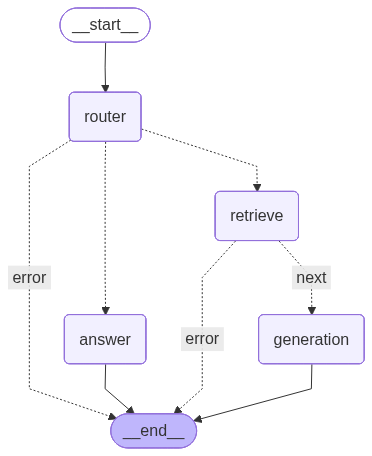

In [103]:
Agent = PDFAgent()
from IPython.display import Image,display
display(Image(Agent.graph.get_graph().draw_mermaid_png()))

In [55]:
from SimplerLLM.language.llm import LLM, LLMProvider

# Create LLM instance
llm = LLM.create(provider=LLMProvider.ANTHROPIC, model_name="claude-3-5-sonnet-20241022")

# Generate response
response = llm.generate_response(prompt="Explain quantum computing in simple terms")
print(response)

Attempt 1 failed: 401 Client Error: Unauthorized for url: https://api.anthropic.com/v1/messages
Attempt 2 failed: 401 Client Error: Unauthorized for url: https://api.anthropic.com/v1/messages
Attempt 3 failed: 401 Client Error: Unauthorized for url: https://api.anthropic.com/v1/messages
All retry attempts failed.
None


In [54]:
from SimplerLLM.language.llm import LLM, LLMProvider
import SimplerLLM.language.llm as llm

# Create primary and secondary LLMs
primary_llm = LLM.create(provider=LLMProvider.OPENAI, model_name="gpt-4o")
secondary_llm = LLM.create(provider=LLMProvider.ANTHROPIC, model_name="claude-3-5-sonnet-20241022")

# Create reliable LLM with automatic failover
reliable_llm = llm.ReliableLLM(primary_llm, secondary_llm)

# If primary fails, automatically uses secondary
response = reliable_llm.generate_response(prompt="Explain machine learning")
print(response)

AttributeError: 'OpenAILLM' object has no attribute 'ReliableLLM'

In [57]:
from SimplerLLM.tools.generic_loader import load_content

# Load from various sources
pdf_content = load_content("./docs/"+pdf_paths[0])

pdf_content


TextDocument(file_size=4987758, word_count=14094, character_count=93053, content='PreFLMR: Scaling Up Fine-Grained Late-Interaction Multi-modal\nRetrievers\n*Weizhe Lin, Jingbiao Mei, Jinghong Chen, Bill Byrne\nDepartment of Engineering\nUniversity of Cambridge\nCambridge, United Kingdom CB2 1PZ\n{wl356, jm2245, jc2124, wjb31}@cam.ac.uk\nAbstract\nLarge Multimodal Models (LMMs) excel in\nnatural language and visual understanding\nbut are challenged by exacting tasks such as\nKnowledge-based Visual Question Answering\n(KB-VQA) which involve the retrieval of rel-\nevant information from document collections\nto use in shaping answers to questions. We\npresent an extensive training and evaluation\nframework, M2KR, for KB-VQA. M2KR con-\ntains a collection of vision and language tasks\nwhich we have incorporated into a single suite\nof benchmark tasks for training and evalu-\nating general-purpose multi-modal retrievers.\nWe use M2KR to develop PreFLMR, a pre-\ntrained version of the recen